[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2026/blob/main/Lab1-NetworkSci-PSN/notebooks/02-pasient_likhetsnettverk_iris.ipynb)


Versjon 2025.12.02 - A. Lundervold

Lab 1: bruk `elmed219-2025` conda-miljøet


# Pasient-likhetsnettverk med IRIS-data

## En praktisk introduksjon til nettverksbasert likhetsanalyse


## 🌸 Hvorfor IRIS-blomster?

I denne notebooken skal vi lære å bygge **pasient-likhetsnettverk** (Patient Similarity Networks, PSN). Men i stedet for å starte med komplekse pasientdata, bruker vi det klassiske IRIS-blomsterdatasettet som et pedagogisk eksempel.

**Tenk på det slik:**
- Hver blomst er som en "pasient"
- De fire målingene (kronbladlengde, -bredde, osv.) er som "kliniske variabler"
- De tre artene (setosa, versicolor, virginica) er som "diagnosegrupper"

Dette datasettet er ideelt for å lære PSN fordi:
1. **Velkjent** – de fleste har møtt det før, så vi kan fokusere på metodikken
2. **Passende størrelse** – 150 datapunkter gir meningsfulle nettverk uten å være overveldende
3. **Tydelige klynger** – demonstrerer community detection på en intuitiv måte
4. **4 features** – enkelt nok til å forstå matematikken


## 🎯 Læringsmål

Etter denne notebooken skal du kunne:

1. Forstå hvordan man bygger et likhetsnettverk fra egenskaps-data (features)
2. Beregne likhet mellom datapunkter ved hjelp av Euklidsk avstand
3. Visualisere nettverk med NetworkX
4. Tolke nettverksstrukturer og hva de sier om dataene
5. Anvende community detection for å finne naturlige grupperinger
6. Overføre disse konseptene til kliniske pasientdata


---
## Steg 1: Last inn nødvendige biblioteker


In [56]:
# Undertrykk advarsler for renere output
import warnings
warnings.filterwarnings('ignore', message='scipy._lib.messagestream.MessageStream size changed')

# Numeriske beregninger og databehandling
import numpy as np
import pandas as pd

# Visualisering
import matplotlib.pyplot as plt
import seaborn as sns

# Nettverksanalyse
import networkx as nx

# Data
from sklearn.datasets import load_iris

# Hjelpefunksjoner
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, HTML
from typing import Dict, List, Tuple

print("Alle biblioteker er lastet inn! ✓")


Alle biblioteker er lastet inn! ✓


---
## Steg 2: Last inn og utforsk IRIS-datasettet


In [57]:
# Last inn IRIS-datasettet
iris = load_iris()

# Pakk ut data
X = iris.data    # Features: de 4 målingene for hver blomst
y = iris.target  # Målvariabel: art (0=setosa, 1=versicolor, 2=virginica)
species = iris.target_names  # Artsnavn

print("="*50)
print("IRIS-DATASETTET")
print("="*50)
print(f"Antall blomster: {X.shape[0]}")
print(f"Antall features: {X.shape[1]}")
print(f"\nArter: {list(species)}")
print(f"\nFeatures (målinger):")
for i, name in enumerate(iris.feature_names):
    print(f"  {i+1}. {name}")


IRIS-DATASETTET
Antall blomster: 150
Antall features: 4

Arter: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]

Features (målinger):
  1. sepal length (cm)
  2. sepal width (cm)
  3. petal length (cm)
  4. petal width (cm)


<details>
<summary>🐍 <b>Dypdykk: Hva er np.str_('setosa')?</b> (klikk for å utvide)</summary>

### NumPy-strenger vs. Python-strenger

I outputen over ser du `np.str_('setosa')` i stedet for bare `'setosa'`. Dette er fordi NumPy har **sine egne datatyper** for å matche arrays.

#### Hvorfor?

Når du henter data fra en NumPy-array, får du NumPy-typer:

```python
iris.target_names        # NumPy-array av strenger
# → array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

iris.target_names[0]     # Første element
# → np.str_('setosa')    # NumPy-streng, ikke vanlig Python-streng
```

#### Sammenligning av typer

| Type | Eksempel | Kilde |
|------|----------|-------|
| `str` | `'setosa'` | Vanlig Python-streng |
| `np.str_` | `np.str_('setosa')` | Fra NumPy-array |

#### Er det noen praktisk forskjell?

**Nesten aldri!** NumPy-strenger fungerer som vanlige Python-strenger:

```python
np.str_('setosa') == 'setosa'       # ✓ True
np.str_('setosa') in ['setosa']     # ✓ True
f"Art: {np.str_('setosa')}"         # ✓ "Art: setosa"
```

#### Konvertering (hvis nødvendig)

```python
# Fra NumPy til Python
str(np.str_('setosa'))      # → 'setosa' (vanlig str)

# Hele arrayen til liste av Python-strenger
list(iris.target_names)     # → ['setosa', 'versicolor', 'virginica']
```

#### Når vises dette?

- I Jupyter/IPython vises `np.str_()` i raw output
- I `print()` vises bare verdien: `setosa`

```python
print(iris.target_names[0])  # Output: setosa (uten np.str_)
iris.target_names[0]         # Output: np.str_('setosa')
```

**Konklusjon:** Du trenger sjelden å tenke på dette – det er mest en visuell forskjell i notebook-output!

</details>


### 🔍 La oss se på noen eksempler


In [58]:
# Lag en pen DataFrame for visning
df = pd.DataFrame(X, columns=iris.feature_names)
df['art'] = [species[i] for i in y]

# Vis de første blomstene fra hver art
print("Eksempler fra datasettet:")
print("\n--- SETOSA (blomst 0-2) ---")
display(df[df['art'] == 'setosa'].head(3))
print("\n--- VERSICOLOR (blomst 50-52) ---")
display(df[df['art'] == 'versicolor'].head(3))
print("\n--- VIRGINICA (blomst 100-102) ---")
display(df[df['art'] == 'virginica'].head(3))


Eksempler fra datasettet:

--- SETOSA (blomst 0-2) ---


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),art
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa



--- VERSICOLOR (blomst 50-52) ---


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),art
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor



--- VIRGINICA (blomst 100-102) ---


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),art
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica


---
## Steg 3: Opprett en tom graf

Vi bruker NetworkX til å lage en **vektet, urettet graf** $G = (V, E)$ hvor:
- $V$ = noder (blomster/"pasienter")
- $E$ = kanter (forbindelser basert på likhet)


In [59]:
# Opprett en tom, urettet graf
G = nx.Graph()

print("Graf opprettet!")
print(f"Type: {type(G)}")


Graf opprettet!
Type: <class 'networkx.classes.graph.Graph'>


---
## Steg 4: Legg til noder (blomstene)

Hver blomst blir en node i nettverket. Vi lagrer også hvilken art den tilhører som et attributt.


In [60]:
# Legg til en node for hver blomst
for i in range(len(X)):
    G.add_node(i, species=species[y[i]])

print(f"Antall noder i nettverket: {G.number_of_nodes()}")
print(f"\nEksempel på node-attributter:")
print(f"  Node 0: {G.nodes[0]}")
print(f"  Node 50: {G.nodes[50]}")
print(f"  Node 100: {G.nodes[100]}")


Antall noder i nettverket: 150

Eksempel på node-attributter:
  Node 0: {'species': np.str_('setosa')}
  Node 50: {'species': np.str_('versicolor')}
  Node 100: {'species': np.str_('virginica')}


---
## Steg 5: Beregn likhet og legg til kanter

### 📐 Matematisk forklaring

For å bygge et likhetsnettverk må vi definere hvor "like" to blomster er. Vi gjør dette i to steg:

#### 1. Euklidsk avstand
For to blomster $i$ og $j$ med feature-vektorer $X_i$ og $X_j$ i 4D-rom:

$$d_{ij} = \|X_i - X_j\| = \sqrt{\sum_{k=1}^4 (X_{i,k} - X_{j,k})^2}$$

hvor $X_{i,k}$ er den $k$-te featuren til blomst $i$.

#### 2. Transformasjon til likhet
Avstand er det motsatte av likhet. Vi transformerer derfor:

$$s_{ij} = \frac{1}{1 + d_{ij}}$$

**Egenskaper ved denne transformasjonen:**
- $s_{ij} \in (0, 1]$ – likheten er begrenset mellom 0 og 1
- Når $d_{ij} = 0$ (identiske blomster): $s_{ij} = 1$
- Når $d_{ij} \to \infty$: $s_{ij} \to 0$
- Symmetrisk: $s_{ij} = s_{ji}$


### 🧮 Eksempelberegning

La oss beregne likheten mellom blomst 0 og blomst 1:


In [61]:
# Vis målingene for blomst 0 og 1
print("Blomst 0 (setosa):", X[0])
print("Blomst 1 (setosa):", X[1])

# Beregn Euklidsk avstand steg for steg
diff = X[0] - X[1]
print(f"\nForskjell (X_0 - X_1): {diff}")

squared_diff = diff ** 2
print(f"Kvadrert forskjell: {squared_diff}")

sum_squared = np.sum(squared_diff)
print(f"Sum av kvadrater: {sum_squared:.4f}")

distance = np.sqrt(sum_squared)
print(f"Euklidsk avstand: {distance:.4f}")

# Transformer til likhet
similarity = 1 / (1 + distance)
print(f"\nLikhet: {similarity:.4f}")


Blomst 0 (setosa): [5.1 3.5 1.4 0.2]
Blomst 1 (setosa): [4.9 3.  1.4 0.2]

Forskjell (X_0 - X_1): [0.2 0.5 0.  0. ]
Kvadrert forskjell: [0.04 0.25 0.   0.  ]
Sum av kvadrater: 0.2900
Euklidsk avstand: 0.5385

Likhet: 0.6500


### Legg til alle kanter


In [62]:
# Beregn likhet mellom alle par av blomster og legg til kanter
for i in range(len(X)):
    for j in range(i+1, len(X)):  # Unngå duplikater (i,j) og (j,i)
        # Beregn Euklidsk avstand
        distance = np.linalg.norm(X[i] - X[j])
        
        # Transformer til likhet
        similarity = 1 / (1.0 + distance)
        
        # Legg til kant med likhet som vekt
        G.add_edge(i, j, weight=similarity)

print(f"Antall kanter: {G.number_of_edges()}")
print(f"\n(For 150 noder er maks antall kanter = 150*149/2 = {150*149//2})")

# Vis noen eksempler på kanter
print("\nEksempler på kantvekter (likhet):")
for i, (u, v, data) in enumerate(G.edges(data=True)):
    if i >= 5:
        break
    print(f"  Kant {u} — {v}: likhet = {data['weight']:.3f}")


Antall kanter: 11175

(For 150 noder er maks antall kanter = 150*149/2 = 11175)

Eksempler på kantvekter (likhet):
  Kant 0 — 1: likhet = 0.650
  Kant 0 — 2: likhet = 0.662
  Kant 0 — 3: likhet = 0.607
  Kant 0 — 4: likhet = 0.876
  Kant 0 — 5: likhet = 0.619


<details>
<summary>🔢 <b>Dypdykk: Hvorfor er maks antall kanter 150×149/2?</b> (klikk for å utvide)</summary>

### Formelen for maksimalt antall kanter

I en **urettet graf** uten løkker (self-loops), der hver node kan kobles til alle andre noder:

$$\text{Maks kanter} = \frac{n(n-1)}{2}$$

### Hvorfor denne formelen?

**Steg 1:** Hver av de $n$ nodene kan kobles til $n-1$ andre noder (alle unntatt seg selv).

**Steg 2:** Dette gir $n \times (n-1)$ mulige "forbindelser"...

**Steg 3:** ...men vi teller hver kant **dobbelt!** (A→B og B→A er samme kant i en urettet graf)

**Derfor deler vi på 2:**

```
150 noder × 149 mulige naboer = 22 350 "forbindelser"
22 350 / 2 = 11 175 unike kanter ✓
```

### Visuelt eksempel med n=4

```
    A ─── B
    │ ╲ ╱ │
    │  ╳  │
    │ ╱ ╲ │
    C ─── D

Maks kanter = 4×3/2 = 6 ✓
Kantene: AB, AC, AD, BC, BD, CD
```

### Python: `//` vs `/`

```python
150*149//2   # → 11175  (heltall)
150*149/2    # → 11175.0 (flyttall)
```

`//` er **heltallsdivisjon** – gir et rent heltall uten desimaler.

### Hvorfor har vi akkurat 11 175 kanter?

Fordi vi lager en **komplett graf** – alle mulige par av blomster er koblet sammen. Hver kant har en vekt (similarity) som sier hvor like de to blomstene er.

| Graf-type | Beskrivelse | Antall kanter |
|-----------|-------------|---------------|
| Komplett | Alle noder koblet | $\frac{n(n-1)}{2}$ |
| Sparse | Kun noen forbindelser | $< \frac{n(n-1)}{2}$ |
| Terskelbasert | Kun kanter over en terskel | Varierer |

</details>


---
## Steg 6: Visualiser nettverket 🎨

Nå kommer det spennende – å se nettverket! Vi farger nodene etter art og kantene etter likhetsstyrke.


Viser 4,193 av 11,175 kanter (terskel ≥ 0.4)


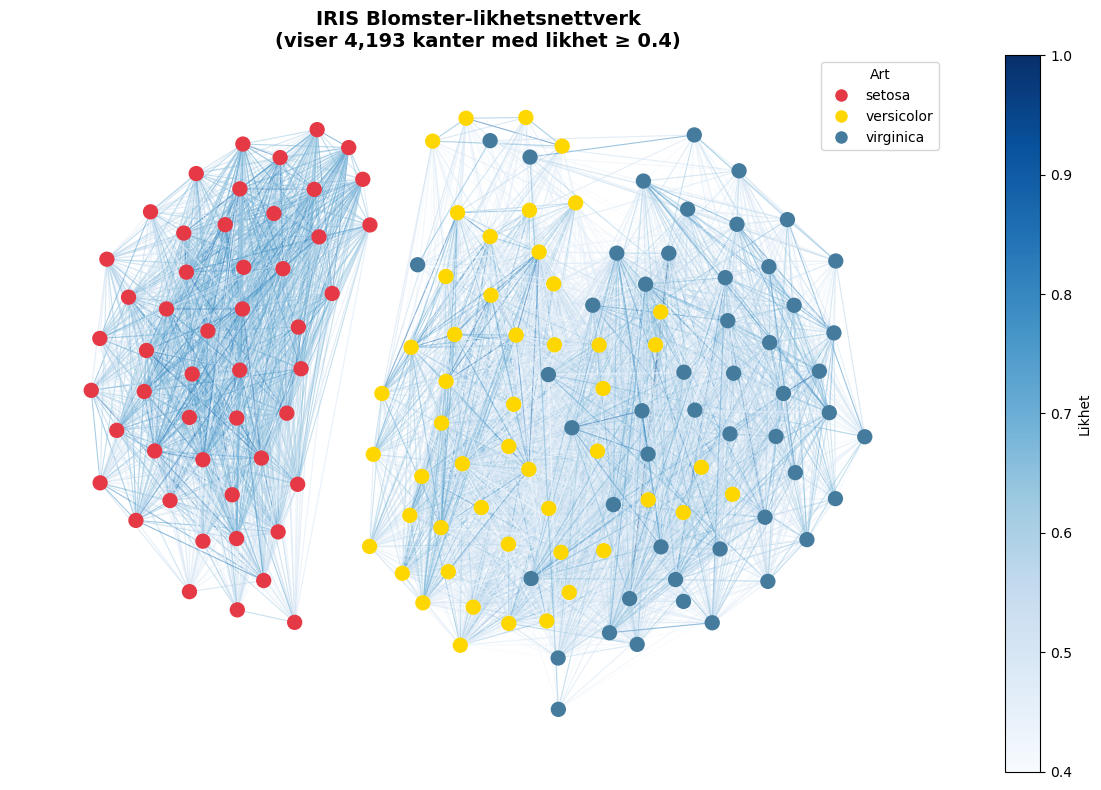

In [63]:
# Sjekk at grafen er bygget
if G.number_of_edges() == 0:
    print("⚠️  FEIL: Grafen har ingen kanter!")
    print("    Kjør cellene ovenfor (Steg 3-5) først for å bygge nettverket.")
else:
    # Opprett figur
    fig, ax = plt.subplots(figsize=(12, 8))

    # Definer farger for hver art (fargeblindevennlig palett)
    color_dict = {
        'setosa': '#E63946',      # Rød
        'versicolor': '#FFD700',  # Sterk gul (gold)
        'virginica': '#457B9D'    # Blå
    }

    # Lag fargeliste for noder basert på art
    color_map = [color_dict[G.nodes[node]['species']] for node in G.nodes]

    # Beregn layout (spring layout simulerer krefter mellom nodene)
    pos = nx.spring_layout(G, k=1, seed=42)

    # --- Filtrer ut kun de sterkeste kantene for visualisering ---
    # Med 11175 kanter blir grafen uleselig. Vi viser kun kanter med høy likhet.
    similarity_threshold = 0.4  # Juster denne for å se flere/færre kanter

    # Finn kanter over terskelen
    strong_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= similarity_threshold]
    strong_weights = [G[u][v]['weight'] for u, v in strong_edges]

    print(f"Viser {len(strong_edges):,} av {G.number_of_edges():,} kanter (terskel ≥ {similarity_threshold})")

    # Tegn først kantene (de som er over terskelen)
    if len(strong_edges) > 0:
        nx.draw_networkx_edges(G, pos, 
                               edgelist=strong_edges,
                               edge_color=strong_weights,
                               width=0.8,
                               alpha=0.5,
                               edge_cmap=plt.cm.Blues,
                               ax=ax)

    # Tegn deretter nodene (over kantene)
    nx.draw_networkx_nodes(G, pos,
                           node_color=color_map,
                           node_size=100,
                           ax=ax)

    # Legg til forklaring (legend)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor=color, label=species_name, markersize=10)
        for species_name, color in color_dict.items()
    ]
    ax.legend(handles=legend_elements, loc='upper right', title='Art')

    # Legg til tittel
    ax.set_title(f"IRIS Blomster-likhetsnettverk\n(viser {len(strong_edges):,} kanter med likhet ≥ {similarity_threshold})", 
                 fontsize=14, fontweight='bold')

    # Legg til fargeskala for kanter
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, 
                               norm=plt.Normalize(vmin=similarity_threshold, vmax=1.0))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Likhet')

    ax.axis('off')
    plt.tight_layout()
    plt.show()


**Figur 1: IRIS Blomster-likhetsnettverk.** Nettverksvisualisering av 150 iris-blomster basert på likhet i fire morfologiske mål (begerblad- og kronbladlengde/-bredde). Hver node representerer én blomst, farget etter art: setosa (rød), versicolor (gul) og virginica (blå). Kanter forbinder blomsterpar med likhet ≥ 0.4, der mørkere blåfarge indikerer høyere likhet. Nodeplasseringen er beregnet med Fruchterman-Reingold force-directed layout, som plasserer like noder nær hverandre. Legg merke til den tydelige separasjonen av setosa (venstre klynge), mens versicolor og virginica overlapper betydelig (høyre klynge) – dette reflekterer biologisk at sistnevnte arter har mer lignende blomstermorfologi.

---

### 🔍 Tolkning av visualiseringen

**Merk:** Vi viser kun kanter med høy likhet (≥ 0.4) for å gjøre grafen leselig. Den komplette grafen har 11 175 kanter!

Legg merke til:

1. **Tre tydelige klynger** – nettverket viser naturlig separasjon mellom de tre artene
2. **Setosa (rød) står alene** – denne arten har få sterke forbindelser til de andre
3. **Versicolor og Virginica overlapper** – disse to artene har noen sterke forbindelser på tvers
4. **Tette klynger** – blomster av samme art har mange sterke forbindelser seg imellom
5. **Kantfarge** – mørkere blå = høyere likhet

**Prøv selv:** Endre `similarity_threshold` til 0.3 eller 0.7 og kjør cellen på nytt for å se hvordan nettverket endrer seg!

**Klinisk analogi:** Tenk deg at de tre klyngene representerer pasienter med ulike sykdomstyper. Sterke kanter viser pasienter som ligner mye på hverandre.


---
## Steg 7: Nabomatrisen (adjacency matrix)

Nabomatrisen er en matematisk representasjon av nettverket som en matrise. Element $(i,j)$ inneholder likheten mellom node $i$ og $j$.


In [64]:
# Konverter nettverket til en pandas DataFrame
adj_matrix = nx.to_pandas_adjacency(G, weight='weight')

print("Nabomatrisens dimensjoner:", adj_matrix.shape)
print("\nDe første 5×5 elementene:")
display(adj_matrix.iloc[:5, :5].round(3))


Nabomatrisens dimensjoner: (150, 150)

De første 5×5 elementene:


,0,1,2,3,4
0,0.000,0.650,0.662,0.607,0.876
1,0.650,0.000,0.769,0.751,0.622
2,0.662,0.769,0.000,0.803,0.662
3,0.607,0.751,0.803,0.000,0.607
4,0.876,0.622,0.662,0.607,0.000


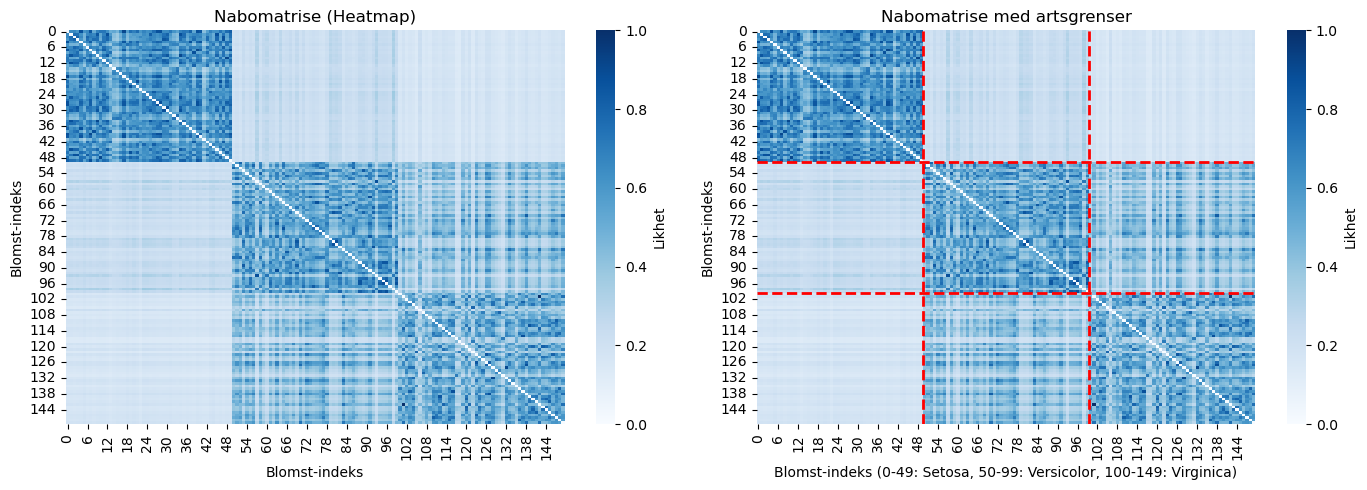


TOLKNING AV NABOMATRISEN

📊 Blokkstruktur:
   • Blokk 0-49:    Setosa (øverst til venstre)
   • Blokk 50-99:   Versicolor (midten)
   • Blokk 100-149: Virginica (nederst til høyre)

📌 Hva ser vi?
   • Mørkere diagonalblokker = høy likhet innad i arter
   • Lysere off-diagonal blokker = lavere likhet mellom arter
   • Setosa-blokken er tydeligst separert (lysest mot andre)
   • Versicolor/Virginica har mer overlapp (mørkere mellom disse)



In [65]:
# Visualiser nabomatrisen som heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Enkel heatmap
sns.heatmap(adj_matrix, cmap='Blues', ax=ax1, cbar_kws={'label': 'Likhet'})
ax1.set_title('Nabomatrise (Heatmap)', fontsize=12)
ax1.set_xlabel('Blomst-indeks')
ax1.set_ylabel('Blomst-indeks')

# Plot 2: Med artsgrenser markert
sns.heatmap(adj_matrix, cmap='Blues', ax=ax2, cbar_kws={'label': 'Likhet'})

# Marker grensene mellom arter (50 blomster per art)
for boundary in [50, 100]:
    ax2.axhline(y=boundary, color='red', linestyle='--', linewidth=2)
    ax2.axvline(x=boundary, color='red', linestyle='--', linewidth=2)

ax2.set_title('Nabomatrise med artsgrenser', fontsize=12)
ax2.set_xlabel('Blomst-indeks (0-49: Setosa, 50-99: Versicolor, 100-149: Virginica)')
ax2.set_ylabel('Blomst-indeks')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TOLKNING AV NABOMATRISEN")
print("="*60)
print("""
📊 Blokkstruktur:
   • Blokk 0-49:    Setosa (øverst til venstre)
   • Blokk 50-99:   Versicolor (midten)
   • Blokk 100-149: Virginica (nederst til høyre)

📌 Hva ser vi?
   • Mørkere diagonalblokker = høy likhet innad i arter
   • Lysere off-diagonal blokker = lavere likhet mellom arter
   • Setosa-blokken er tydeligst separert (lysest mot andre)
   • Versicolor/Virginica har mer overlapp (mørkere mellom disse)
""")


**Figur 2: Nabomatrise (adjacency matrix) for IRIS-likhetsnettverk.** *Venstre panel:* Komplett 150×150 nabomatrise der hver celle $(i,j)$ representerer likheten mellom blomst $i$ og blomst $j$. Mørkere blåfarge indikerer høyere likhet. Diagonalen (selvlikhet) er satt til 0 for visualisering. *Høyre panel:* Samme matrise med røde stiplede linjer som markerer artsgrensene (0-49: setosa, 50-99: versicolor, 100-149: virginica). Den tydelige blokkstrukturen langs diagonalen viser at blomster innad i hver art er mer like hverandre enn blomster på tvers av arter. Setosa-blokken (øverst til venstre) er tydeligst avgrenset med svært lave likhetsverdier mot de andre artene, mens versicolor-virginica-blokkene viser mer overlapp (mørkere off-diagonal elementer).


---
## Steg 8: Grunnleggende nettverksanalyse

For å kvantifisere strukturen i et nettverk bruker vi **nettverksmetrikker**. Disse tallene forteller oss noe om hvordan nodene er forbundet og gruppert. Vi skal se på tre viktige metrikker:

### 1️⃣ Nettverkstetthet (Density)

**Intuisjon:** Hvor "fullstappet" er nettverket med kanter? Tenk på et rom fullt av mennesker – hvis alle kjenner alle, er det maksimal tetthet. Hvis bare noen få kjenner hverandre, er tettheten lav.

**Matematisk definisjon:** For en urettet graf med $n$ noder og $m$ kanter:

$$D = \frac{2m}{n(n-1)} = \frac{\text{antall faktiske kanter}}{\text{maks mulige kanter}}$$

- $D = 0$: Ingen kanter (isolerte noder)
- $D = 1$: Komplett graf (alle forbundet med alle)
- Typiske sosiale nettverk: $D \approx 0.01 - 0.1$

### 2️⃣ Klyngekoeffisient (Clustering Coefficient)

**Intuisjon:** "Hvor mye henger vennenes venner sammen?" Hvis du kjenner Per og Kari, kjenner Per og Kari også hverandre? Høy klynging betyr at naboer til en node også er naboer seg imellom – de danner "trekanter".

**Matematisk definisjon:** For en node $i$ med $k_i$ naboer:

$$C_i = \frac{2 \cdot L_i}{k_i(k_i-1)}$$

hvor $L_i$ er antall kanter mellom naboene til node $i$.

**Gjennomsnittlig klyngekoeffisient** for hele nettverket:

$$\bar{C} = \frac{1}{n}\sum_{i=1}^{n} C_i$$

- $C = 0$: Ingen naboer er forbundet (stjerneform)
- $C = 1$: Alle naboer er forbundet (fullstendige klynger)

### 3️⃣ Separasjonsratio (Within/Between Ratio)

**Intuisjon:** Hvor mye mer like er medlemmer av samme gruppe sammenlignet med medlemmer fra ulike grupper? Dette er nøkkelmetrikken for å vurdere om et PSN faktisk fanger opp meningsfulle grupperinger.

**Matematisk definisjon:** 

$$R = \frac{\bar{s}_{\text{innad}}}{\bar{s}_{\text{mellom}}} = \frac{\frac{1}{|E_w|}\sum_{(i,j) \in E_w} s_{ij}}{\frac{1}{|E_b|}\sum_{(i,j) \in E_b} s_{ij}}$$

hvor:
- $E_w$ = kanter mellom noder i *samme* gruppe
- $E_b$ = kanter mellom noder i *ulike* grupper
- $s_{ij}$ = likhet mellom node $i$ og $j$

**Tolkning:**
- $R = 1$: Ingen separasjon (grupper er like hverandre)
- $R > 1$: God separasjon (medlemmer ligner mer på egen gruppe)
- $R > 2$: Sterk separasjon (typisk for veldefinerte klynger)


In [66]:
print("="*50)
print("NETTVERKSANALYSE")
print("="*50)

# Grunnleggende metrikker
print(f"\n📈 Grunnleggende metrikker:")
print(f"   Gjennomsnittlig klyngekoeffisient: {nx.average_clustering(G):.3f}")
print(f"   Nettverkstetthet: {nx.density(G):.3f}")

# Funksjon for å beregne gjennomsnittlig likhet innad/mellom arter
def calculate_species_similarities(G, y):
    """Beregn gjennomsnittlig likhet innad og mellom arter"""
    within_species = {species_name: [] for species_name in iris.target_names}
    between_species = []
    
    for (i, j, w) in G.edges.data('weight'):
        if y[i] == y[j]:  # Samme art
            within_species[iris.target_names[y[i]]].append(w)
        else:  # Ulik art
            between_species.append(w)
    
    print(f"\n🌸 Gjennomsnittlig likhet INNAD i arter:")
    for species_name, similarities in within_species.items():
        print(f"   {species_name}: {np.mean(similarities):.3f}")
    
    print(f"\n🔗 Gjennomsnittlig likhet MELLOM arter: {np.mean(between_species):.3f}")
    
    # Beregn separasjonsratio
    avg_within = np.mean([np.mean(v) for v in within_species.values()])
    avg_between = np.mean(between_species)
    print(f"\n📊 Separasjonsratio (innad/mellom): {avg_within/avg_between:.2f}x")

calculate_species_similarities(G, y)


NETTVERKSANALYSE

📈 Grunnleggende metrikker:
   Gjennomsnittlig klyngekoeffisient: 1.000
   Nettverkstetthet: 1.000

🌸 Gjennomsnittlig likhet INNAD i arter:
   setosa: 0.614
   versicolor: 0.531
   virginica: 0.495

🔗 Gjennomsnittlig likhet MELLOM arter: 0.264

📊 Separasjonsratio (innad/mellom): 2.07x


### 📖 Tolkning av resultatene

**Nettverkstetthet $D = 1.0$**
- Vårt nettverk er **komplett** – alle 11 175 mulige kanter eksisterer
- Dette er fordi vi koblet *alle* par av blomster, uavhengig av likhet
- I praksis bruker man ofte en terskel for å lage et *glissent* (sparse) nettverk

**Klyngekoeffisient $\bar{C} = 1.0$**
- Maksimal klynging! Alle naboer til enhver node er også naboer seg imellom
- Dette følger automatisk av at nettverket er komplett
- For glissne nettverk ville denne metrikken vært mer informativ

**Separasjonsratio $R = 2.07$**
- ⭐ **Dette er den viktigste metrikken for PSN!**
- Blomster av samme art er i gjennomsnitt **2× mer like** hverandre enn blomster fra ulike arter
- Setosa har høyest innad-likhet (0.614) – dette forklarer hvorfor den er så tydelig separert i visualiseringen
- Virginica har lavest (0.495) – mer variasjon innad i arten

**Klinisk relevans:**
- $R > 2$ i et PSN indikerer at pasientgruppene faktisk er forskjellige på en meningsfull måte
- Hvis $R \approx 1$, ville gruppene vært vilkårlige og nettverket lite nyttig


---
## Steg 9: Community Detection (Klyngedeteksjon)

### Hva er Community Detection?

**Community detection** er en teknikk for å finne **naturlige grupperinger** (communities/klynger) i et nettverk – *uten* forhåndskunnskap om hvilke grupper som finnes. Algoritmen ser kun på nettverksstrukturen (hvem som er koblet til hvem, og hvor sterkt) og prøver å finne noder som "hører sammen".

**Intuisjon:** Tenk på et sosialt nettverk. Selv uten å vite hvem som er familie, kollegaer eller venner, kan man ofte gjette grupperinger bare ved å se på hvem som snakker mest med hvem. Communities er grupper der nodene har *tettere forbindelser seg imellom* enn med resten av nettverket.

### 🏥 Klinisk motivasjon: Hvorfor er dette viktig i medisin?

I klinisk praksis står vi ofte overfor et sentralt spørsmål:

> **"Finnes det undergrupper av pasienter som vi ikke visste om?"**

Community detection kan avsløre skjulte pasientsubgrupper basert på kliniske data:

| Klinisk scenario | Hva community detection kan oppdage |
|------------------|-------------------------------------|
| **Kreftbehandling** | Pasienter som responderer likt på kjemoterapi – mulig ny biomarkør? |
| **Psykiatri** | Undertyper av depresjon med ulike symptomprofiler |
| **Diabetes** | Type 2-diabetikere med ulik sykdomsprogresjon |
| **Nevrologi** | Alzheimer-pasienter med ulike kognitive sviktmønstre |
| **Farmakologi** | Pasienter med lik bivirkningsprofil – genetisk årsak? |

**Presisjonsmedisins løfte:** Hvis vi kan identifisere meningsfulle pasientsubgrupper, kan vi tilpasse behandlingen til hver gruppe – i stedet for "one size fits all".

### 📐 Matematisk formulering: Modularitet

Den mest brukte metrikken for å evaluere community-struktur er **modularitet** (Q):

$$Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

hvor:
- $A_{ij}$ = vekten på kanten mellom node $i$ og $j$ (0 hvis ingen kant)
- $k_i, k_j$ = graden (sum av kantvekter) til node $i$ og $j$  
- $m$ = total sum av alle kantvekter i nettverket
- $c_i$ = community-tilhørighet for node $i$
- $\delta(c_i, c_j)$ = 1 hvis $c_i = c_j$ (samme community), ellers 0

**Intuisjon bak formelen:**
- $A_{ij}$ = faktisk forbindelse mellom $i$ og $j$
- $\frac{k_i k_j}{2m}$ = *forventet* forbindelse hvis kanter var tilfeldig fordelt
- Differansen måler om forbindelsen er *sterkere enn forventet*
- Vi summerer kun over par i *samme* community ($\delta = 1$)

**Tolkning av Q:**
- $Q \approx 0$: Ingen community-struktur (like tilfeldig)
- $Q > 0.3$: Moderat community-struktur
- $Q > 0.7$: Sterk community-struktur
- $Q$ kan teoretisk være negativ (verre enn tilfeldig)

### 🔧 Louvain-algoritmen

Vi bruker **Louvain-algoritmen** (Blondel et al., 2008), som er:
- ⚡ **Rask** – skalerer til millioner av noder
- 🎯 **Effektiv** – optimaliserer modularitet iterativt
- 📈 **Hierarkisk** – kan finne communities på flere nivåer

**Algoritmen i korte trekk:**
1. Start med hver node i sin egen community
2. Flytt noder til naboens community hvis det øker $Q$
3. Slå sammen communities til "supernoder"
4. Gjenta til $Q$ ikke kan forbedres mer

### 🔄 Sammenligning med K-means: To veier til samme mål?

Både **community detection** og **K-means** er *uovervåkede* (datadrevet, ikke-styrt klassifikasjon) metoder for å finne grupperinger i data. <br>
Begge kan ta utgangspunkt i den samme datamatrisen (f.eks. en `.csv`-fil med pasienter som rader og kliniske variabler som kolonner). <br>
Men de tenker fundamentalt forskjellig:

```
Samme data → To ulike tilnærminger:

┌─────────────────┐      ┌─────────────────────┐      ┌─────────────────┐
│   Data-matrise  │      │                     │      │                 │
│  (pasienter ×   │─────►│  Beregn avstand/    │─────►│   K-means:      │
│   variabler)    │      │  likhet mellom      │      │   Klynger i     │
│                 │      │  alle par           │      │   feature-rom   │
└─────────────────┘      │                     │      └─────────────────┘
                         │                     │
                         │                     │      ┌─────────────────┐
                         │                     │─────►│   Community     │
                         │                     │      │   detection:    │
                         │                     │      │   Klynger i     │
                         └─────────────────────┘      │   nettverks-rom │
                                                      └─────────────────┘
```

#### Sammenligning

| Aspekt | K-means | Community Detection |
|--------|---------|---------------------|
| **Input** | Datamatrise (feature-vektorer) | Nettverk (noder + kanter) |
| **Antall klynger** | Må spesifiseres på forhånd ($k$) | Bestemmes automatisk |
| **Geometri** | Sfæriske klynger (Euklidsk avstand) | Vilkårlig form |
| **Optimaliseringskriterie** | Minimér intra-klynge varians | Maksimér modularitet |
| **Sentroider** | Ja (klyngesentre) | Nei |
| **Deterministisk** | Nei (avhenger av initialisering) | Nei (kan variere) |

#### Styrker og svakheter

**K-means – styrker:**
- ✅ Enkel og rask
- ✅ Lett å forstå og implementere
- ✅ Gir klyngesentre (nyttig for tolkning)
- ✅ Skalerer godt til store datasett

**K-means – svakheter:**
- ❌ Må velge $k$ på forhånd (hvor mange grupper?)
- ❌ Antar sfæriske klynger (fungerer dårlig på avlange former)
- ❌ Sensitiv for initialisering og uteliggere
- ❌ Bruker kun feature-avstand, ikke relasjonsstruktur

**Community detection – styrker:**
- ✅ Finner antall grupper automatisk
- ✅ Håndterer vilkårlige klyngeformer
- ✅ Utnytter relasjonsstruktur (hvem ligner på hvem)
- ✅ Kan vekte ulike typer likhet

**Community detection – svakheter:**
- ❌ Krever at man først bygger et nettverk
- ❌ Resultat avhenger av nettverkskonstruksjon (terskel, likhetsmål)
- ❌ Kan være beregningsmessig tyngre
- ❌ Gir ikke klyngesentre

#### Når bruke hva?

| Situasjon | Anbefalt metode |
|-----------|-----------------|
| Du vet antall grupper | K-means |
| Ukjent antall grupper | Community detection |
| Sfæriske, kompakte klynger | K-means |
| Uregelmessige klyngeformer | Community detection |
| Relasjoner er viktige | Community detection |
| Trenger klyngesentre | K-means |
| Pasientlikhet er nøkkelen | Community detection (PSN) |

**Oppsummert:** K-means grupperer basert på *hvor nær* punktene er i feature-rommet. Community detection grupperer basert på *hvor tett forbundet* nodene er i nettverket. <br>
For PSN, der vi eksplisitt modellerer pasient-likhet som kanter, er community detection ofte det naturlige valget.

---

### ❓ Det store spørsmålet

Kan Louvain-algoritmen finne de tre IRIS-artene *uten* å vite at de eksisterer? La oss teste!


In [67]:
# Importer community detection
import community.community_louvain as community

# Utfør community detection
communities = community.best_partition(G)

# Analyser resultater
n_communities = len(set(communities.values()))
modularity = community.modularity(communities, G)

print("="*50)
print("COMMUNITY DETECTION (Louvain-algoritmen)")
print("="*50)
print(f"\nAntall communities funnet: {n_communities}")
print(f"Modularitet: {modularity:.3f}")
print("\n(Modularitet måler hvor godt nettverket er delt inn i communities.")
print("Verdier over 0.3 indikerer signifikant community-struktur.)")


COMMUNITY DETECTION (Louvain-algoritmen)

Antall communities funnet: 3
Modularitet: 0.179

(Modularitet måler hvor godt nettverket er delt inn i communities.
Verdier over 0.3 indikerer signifikant community-struktur.)


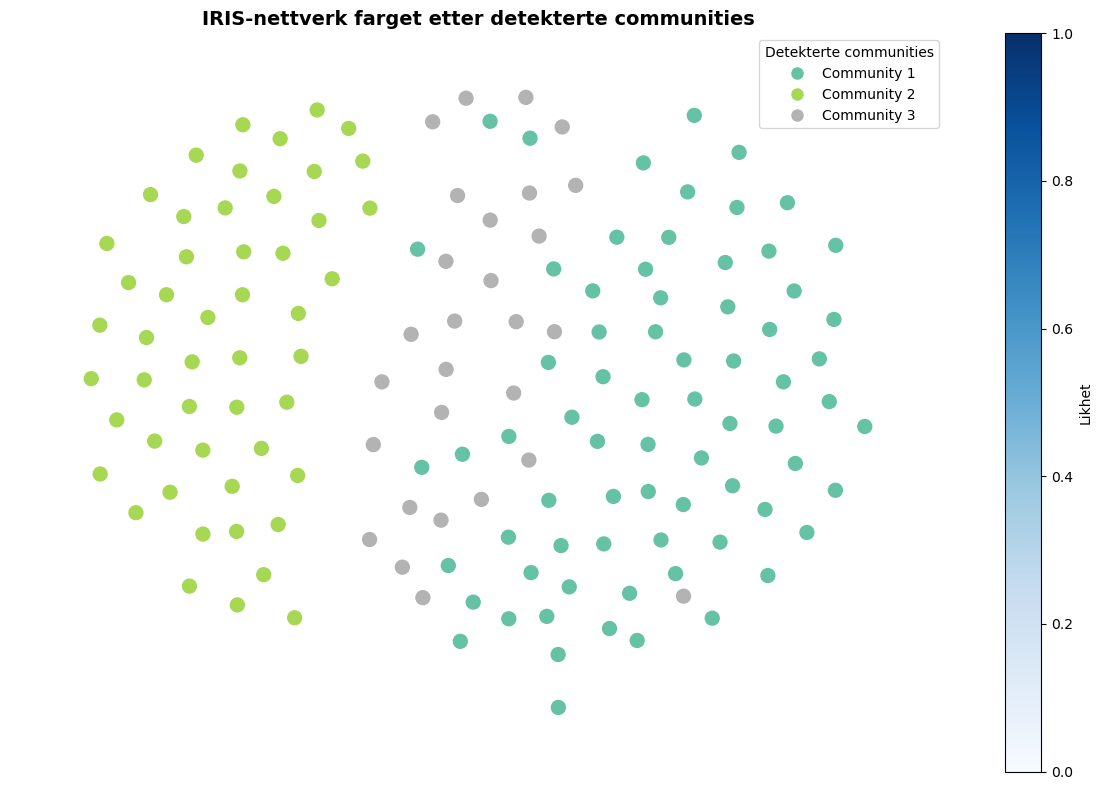

In [68]:
# Visualiser nettverket med community-farger
fig, ax = plt.subplots(figsize=(12, 8))

# Lag farger for communities
community_colors = plt.cm.Set2(np.linspace(0, 1, n_communities))
node_colors = [community_colors[communities[node]] for node in G.nodes()]

# Tegn nettverket
nx.draw(G, 
        pos=pos,  # Bruk samme layout som før
        node_color=node_colors,
        edge_color=edge_weights,
        width=1.0,
        edge_cmap=plt.cm.Blues,
        with_labels=False,
        node_size=100,
        ax=ax)

ax.set_title("IRIS-nettverk farget etter detekterte communities", 
             fontsize=14, fontweight='bold')

# Legg til forklaring
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=community_colors[i], 
               label=f'Community {i+1}', markersize=10)
    for i in range(n_communities)
]
ax.legend(handles=legend_elements, loc='upper right', title='Detekterte communities')

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm.set_array(edge_weights)
plt.colorbar(sm, ax=ax, label='Likhet')

plt.tight_layout()
plt.show()


**Figur 3: IRIS-nettverk farget etter automatisk detekterte communities.** Samme nettverkslayout som Figur 1, men her er nodene farget etter communities identifisert av Louvain-algoritmen – en uovervåket, data-drevet metode som kun bruker nettverksstrukturen uten kjennskap til de faktiske artsklassene. Algoritmen fant 3 communities, noe som tilsvarer antall arter. Sammenlign med Figur 1 for å se hvor godt de detekterte gruppene matcher de faktiske artene. Kantene er farget etter likhetsstyrke (mørkere = høyere likhet). Community detection er en kraftfull teknikk for å oppdage naturlige grupperinger i data uten forhåndskunnskap – i klinisk sammenheng kan dette brukes til å identifisere pasientsubgrupper.

---

### Sammenlign communities med faktiske arter

La oss se hvor godt de detekterte communities samsvarer med de faktiske artene.


In [69]:
# Analyser distribusjon av arter i hver community
community_distribution = {}
for node in G.nodes():
    species_name = G.nodes[node]['species']
    comm_id = communities[node]
    
    if comm_id not in community_distribution:
        community_distribution[comm_id] = {'setosa': 0, 'versicolor': 0, 'virginica': 0}
    community_distribution[comm_id][species_name] += 1

print("\n" + "="*50)
print("FORDELING AV ARTER I HVER COMMUNITY")
print("="*50)
for comm_id in sorted(community_distribution.keys()):
    print(f"\nCommunity {comm_id + 1}:")
    for species_name, count in community_distribution[comm_id].items():
        if count > 0:
            print(f"   {species_name}: {count} blomster")



FORDELING AV ARTER I HVER COMMUNITY

Community 1:
   versicolor: 23 blomster
   virginica: 49 blomster

Community 2:
   setosa: 50 blomster

Community 3:
   versicolor: 27 blomster
   virginica: 1 blomster


### Visuell sammenligning: Community vs. Art

La oss lage en visualisering der vi kan se *begge* klassifiseringene samtidig:
- **Fyllfarge** = Detektert community (Louvain)
- **Kantfarge (ring)** = Faktisk art

Slik kan vi umiddelbart se hvor algoritmen treffer (matching farger) og bommer (ulike farger).


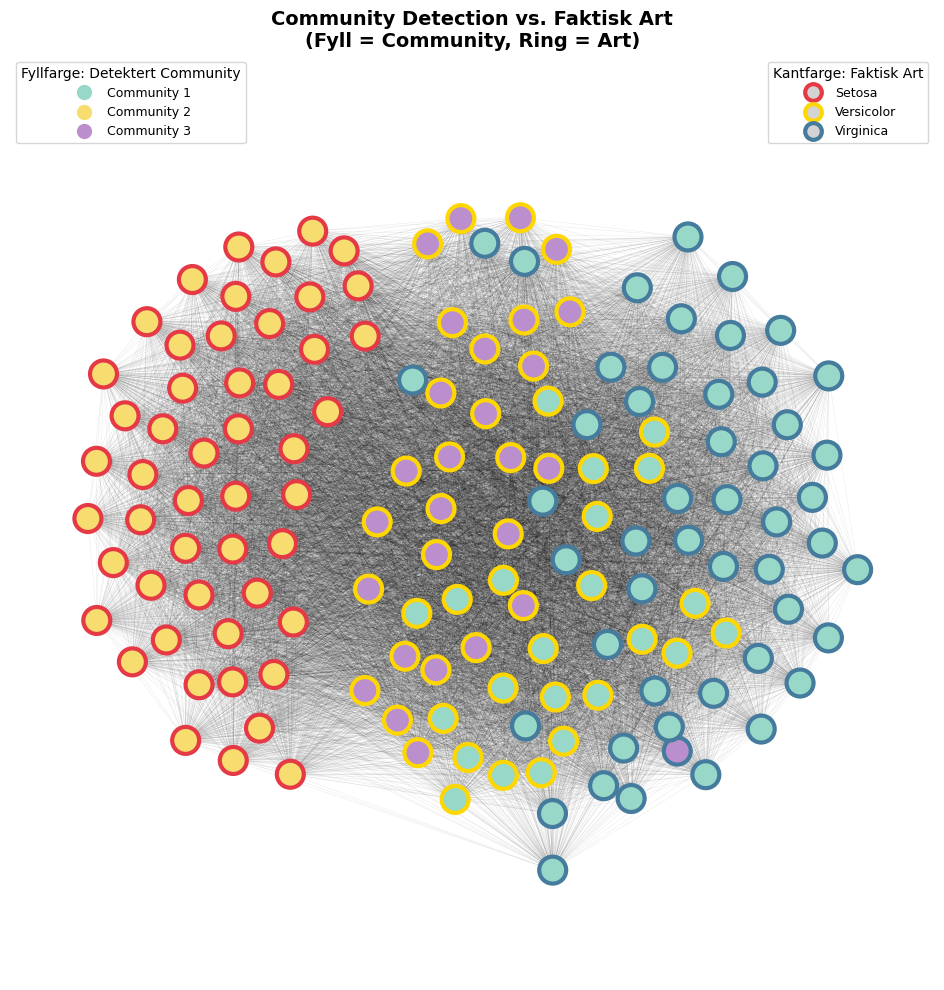


📊 Visuell tolkning:
   • Noder der ring og fyll 'matcher' = korrekt klassifisert
   • Noder der ring og fyll er ulike = feilklassifisert
   • Legg merke til setosa-klyngen (rød ring) - nesten perfekt!


In [70]:
# Avansert visualisering: Community (fyll) + Art (kant)
fig, ax = plt.subplots(figsize=(14, 10))

# Definer farger for arter (kantfarge/ring) - fargeblindevennlig
species_colors = {
    'setosa': '#E63946',      # Rød
    'versicolor': '#FFD700',  # Sterk gul
    'virginica': '#457B9D'    # Blå
}

# Definer farger for communities (fyllfarge) - kontrasterende
community_color_map = {
    0: '#98D8C8',  # Mint/turkis
    1: '#F7DC6F',  # Lys gul  
    2: '#BB8FCE'   # Lilla
}

# Tegn kanter først (i bakgrunnen)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3, ax=ax)

# Tegn hver node med fyllfarge (community) og kantfarge (art)
for node in G.nodes():
    x, y = pos[node]
    comm_id = token = communities[node]
    species_name = G.nodes[node]['species']
    
    # Fyllfarge = community
    fill_color = community_color_map[comm_id]
    # Kantfarge = art
    edge_color = species_colors[species_name]
    
    # Tegn node med tykk kant
    circle = plt.Circle((x, y), 0.035, 
                        facecolor=fill_color, 
                        edgecolor=edge_color, 
                        linewidth=3,
                        zorder=2)
    ax.add_patch(circle)

# Lag legend for communities (fyllfarge)
community_legend = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=community_color_map[i], 
               markersize=12, label=f'Community {i+1}')
    for i in range(n_communities)
]

# Lag legend for arter (kantfarge)
species_legend = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor='lightgray',
               markeredgecolor=color, 
               markeredgewidth=3,
               markersize=12, label=species_name.capitalize())
    for species_name, color in species_colors.items()
]

# Plasser legends
legend1 = ax.legend(handles=community_legend, loc='upper left', 
                    title='Fyllfarge: Detektert Community', fontsize=9)
ax.add_artist(legend1)
ax.legend(handles=species_legend, loc='upper right', 
          title='Kantfarge: Faktisk Art', fontsize=9)

ax.set_title("Community Detection vs. Faktisk Art\n(Fyll = Community, Ring = Art)", 
             fontsize=14, fontweight='bold')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()

# Tell opp matcher
matches = sum(1 for node in G.nodes() 
              if (communities[node] == 2 and G.nodes[node]['species'] == 'setosa') or
                 (communities[node] == 0 and G.nodes[node]['species'] == 'versicolor') or
                 (communities[node] == 1 and G.nodes[node]['species'] == 'virginica'))

# Alternativ telling basert på beste tilordning
print(f"\n📊 Visuell tolkning:")
print(f"   • Noder der ring og fyll 'matcher' = korrekt klassifisert")
print(f"   • Noder der ring og fyll er ulike = feilklassifisert")
print(f"   • Legg merke til setosa-klyngen (rød ring) - nesten perfekt!")


**Figur 4: Visuell sammenligning av detekterte communities og faktiske arter.** Hver node vises med to fargekomponenter: *Fyllfarge* (indre sirkel) representerer den community som Louvain-algoritmen tildelte noden, mens *kantfarge* (tykk ring rundt) representerer nodens faktiske art (rød=setosa, gul=versicolor, blå=virginica). Noder der fyllfargen og ringfargen "hører sammen" er korrekt klassifisert. Legg spesielt merke til setosa-klyngen (venstre) der alle noder har rød ring – disse ble perfekt identifisert. I versicolor/virginica-klyngen (høyre) ser vi mer blanding, noe som reflekterer den biologiske likheten mellom disse artene. Denne visualiseringen gir umiddelbar innsikt i hvor algoritmen lykkes og feiler.


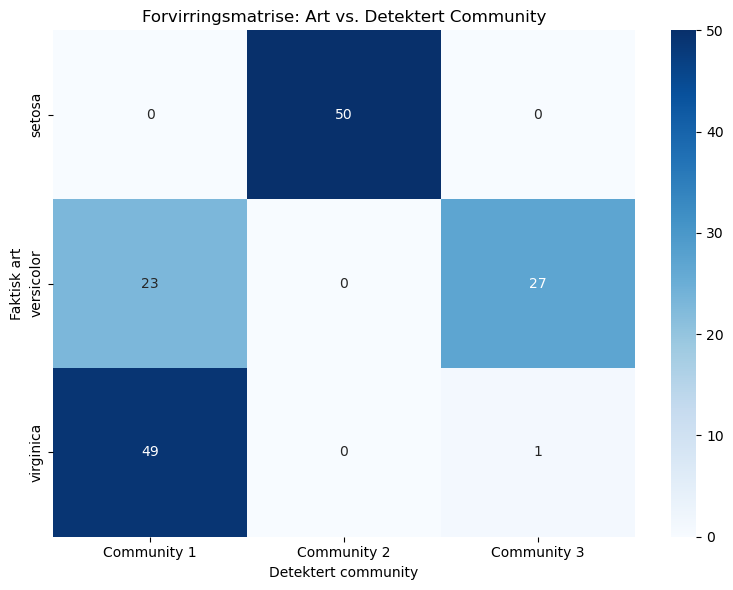


Nøyaktighet (beste tilordning): 84.0%


In [71]:
# Lag en "forvirringsmatrise" (confusion matrix)
cm = np.zeros((3, n_communities))
species_order = ['setosa', 'versicolor', 'virginica']

for comm_id, distribution in community_distribution.items():
    for i, species_name in enumerate(species_order):
        cm[i, comm_id] = distribution[species_name]

# Visualiser
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=[f'Community {i+1}' for i in range(n_communities)],
            yticklabels=species_order,
            ax=ax)

ax.set_title('Forvirringsmatrise: Art vs. Detektert Community', fontsize=12)
ax.set_ylabel('Faktisk art')
ax.set_xlabel('Detektert community')

plt.tight_layout()
plt.show()

# Beregn nøyaktighet (antar optimal tilordning av communities til arter)
# Finn beste match per community
best_matches = cm.max(axis=0).sum()
accuracy = best_matches / 150
print(f"\nNøyaktighet (beste tilordning): {accuracy:.1%}")


**Figur 5: Forvirringsmatrise – sammenligning av faktiske arter og detekterte communities.** Heatmap som viser antall blomster fra hver art (rader) som ble plassert i hver detektert community (kolonner). Tallene i cellene angir antall blomster. Perfekt klassifisering ville gitt en diagonal matrise med 50 i hver diagonalcelle. Her ser vi at setosa (50 blomster) ble perfekt gruppert i én community (Community 2), mens versicolor og virginica viser overlapp – versicolor er delt mellom Community 1 (27) og Community 3 (23), og nesten alle virginica (49 av 50) havnet i Community 3. Den beregnede nøyaktigheten på 84% reflekterer hvor godt de automatisk detekterte communities samsvarer med de faktiske biologiske artene.

---

### 🎯 Tolkning

Forvirringsmatrisen viser oss:
- **Setosa** identifiseres perfekt – alle 50 i én community
- **Versicolor og Virginica** har noe overlapp – dette er forventet fordi disse artene faktisk har mer lignende egenskaper

Dette er et viktig funn: **nettverksbasert analyse kan avsløre naturlige grupperinger i data!**

**Klinisk relevans:** I pasientdata kan slike communities representere:
- Ulike sykdomssubtyper
- Pasienter med lignende behandlingsrespons
- Risikogrupper


---
## 📚 Oppsummering og neste steg

### Hva har vi lært?

1. **Bygge likhetsnettverk** – transformere feature-data til nettverksrepresentasjon
2. **Beregne likhet** – bruke Euklidsk avstand og transformasjon til likhetsmål
3. **Visualisere nettverk** – se strukturer og klynger i dataene
4. **Analysere nettverksegenskaper** – beregne metrikker og sammenligne grupper
5. **Community detection** – finne naturlige grupperinger automatisk

### Fra blomster til pasienter

Prinsippene vi har lært kan overføres direkte til kliniske data:

| IRIS-data | Pasientdata |
|-----------|-------------|
| Blomst | Pasient |
| Kronbladlengde, etc. | Labverdier, vitale tegn, etc. |
| Art (setosa, etc.) | Diagnose eller behandlingsrespons |
| Likhetsnettverk | Pasient-likhetsnettverk (PSN) |
| Community | Pasientsubgruppe |

### Neste notebook

I de neste notebookene skal vi anvende disse teknikkene på:
- Syntetiske pasientdata
- IQ-data fra ABCD-studien
- Mer avanserte likhetsmetrikker


---
## 💡 Øvelser

Prøv disse 10 øvelsene for å fordype forståelsen. Løsninger finnes i `02a-pasient_likhetsnettverk_iris_losninger.ipynb`.

---

### Øvelse 1: Alternativ likhetsmål – Gaussisk kjerne ⭐

**Oppgave:** Modifiser koden til å bruke Gaussisk kjerne (RBF) i stedet for vår inverse avstand:

$$s_{ij} = \exp\left(-\frac{d_{ij}^2}{2\sigma^2}\right)$$

a) Implementer denne likhetsformelen  
b) Eksperimenter med ulike verdier av $\sigma$ (0.5, 1.0, 2.0, 5.0)  
c) Hvordan påvirker $\sigma$ nettverksstrukturen og community detection?

**Motivasjon:** Gaussisk kjerne er svært vanlig i maskinlæring (SVM, kernel methods) og gir en "mykere" avstandsfunksjon. $\sigma$ kontrollerer hvor raskt likheten avtar med avstand.

<details>
<summary>💡 Hint</summary>

```python
sigma = 1.0
similarity = np.exp(-(distance**2) / (2 * sigma**2))
```
Liten $\sigma$ → kun veldig nære noder får høy likhet  
Stor $\sigma$ → alle noder får relativt lik similarity
</details>

---

### Øvelse 2: Terskelbasert glissent nettverk ⭐

**Oppgave:** I stedet for et komplett nettverk, bygg et *glissent* (sparse) nettverk der kun kanter med likhet over en terskel inkluderes.

a) Bygg nettverk med terskel = 0.3, 0.5, 0.7  
b) Beregn nettverkstetthet for hver terskel  
c) Kjør community detection på hvert nettverk – endres resultatene?

**Motivasjon:** Komplette nettverk er beregningsmessig tunge og kan "skjule" viktige strukturer. Glissne nettverk fremhever de sterkeste forbindelsene.

<details>
<summary>💡 Hint</summary>

```python
threshold = 0.5
G_sparse = nx.Graph()
for i in range(len(X)):
    G_sparse.add_node(i, species=species[y[i]])
    for j in range(i+1, len(X)):
        similarity = 1 / (1 + np.linalg.norm(X[i] - X[j]))
        if similarity >= threshold:  # Kun legg til hvis over terskel
            G_sparse.add_edge(i, j, weight=similarity)
```
</details>

---

### Øvelse 3: Klinisk scenario – Design et PSN ⭐⭐

**Oppgave:** Tenk på en klinisk setting der du ville brukt PSN. Beskriv:

a) Hvilken pasientpopulasjon (f.eks. hjertesvikt, diabetes, kreft)?  
b) Hvilke variabler ville du inkludert (minst 5)?  
c) Hvordan ville du beregnet likhet mellom pasienter?  
d) Hva kunne communities representere klinisk?  
e) Hvordan ville du validert resultatene?

**Motivasjon:** PSN er et verktøy – verdien ligger i klinisk anvendelse. Å tenke gjennom et realistisk scenario tvinger frem forståelse av metodens styrker og begrensninger.

<details>
<summary>💡 Hint – Eksempel: Type 2 Diabetes</summary>

- **Variabler:** HbA1c, fastende glukose, BMI, alder, blodtrykk, kolesterol
- **Likhetsmål:** Gower distance (blanding av kontinuerlige og kategoriske)
- **Communities:** Ulike sykdomsprofiler (metabolsk syndrom, insulinresistent, etc.)
- **Validering:** Sjekk om communities har ulik behandlingsrespons
</details>

---

### Øvelse 4: Normaliser features før avstands-beregning ⭐

**Oppgave:** IRIS-features har ulik skala (cm). Hva skjer hvis vi normaliserer dem først?

a) Normaliser hver feature til gjennomsnitt=0, standardavvik=1 (z-skår)  
b) Bygg et nytt nettverk med normaliserte data  
c) Sammenlign community detection-resultater med det opprinnelige nettverket

**Motivasjon:** I kliniske data har variabler vidt forskjellig skala (alder 0-100, blodtrykk 60-200, BMI 15-50). Uten normalisering vil variabler med stor range dominere avstands-beregningen.

<details>
<summary>💡 Hint</summary>

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
# Bygg nettverk med X_normalized i stedet for X
```
</details>

---

### Øvelse 5: Sammenlign med K-means ⭐⭐

**Oppgave:** Kjør K-means clustering (k=3) på IRIS-dataene og sammenlign med community detection.

a) Implementer K-means med scikit-learn  
b) Beregn Adjusted Rand Index (ARI) for begge metoder mot faktiske arter  
c) Hvilken metode gir best resultat? Hvorfor tror du det?

**Motivasjon:** K-means er en klassisk klyngemetode. Å sammenligne gir innsikt i når nettverksbaserte metoder har fordeler.

<details>
<summary>💡 Hint</summary>

```python
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

ari_kmeans = adjusted_rand_score(y, kmeans_labels)
ari_community = adjusted_rand_score(y, list(communities.values()))
```
</details>

---

### Øvelse 6: Sentralitetsanalyse – Finn "hub-blomster" ⭐⭐

**Oppgave:** Bruk sentralitetsmål til å finne de mest "sentrale" blomstene i nettverket.

a) Beregn *degree centrality* og *eigenvector centrality* for alle noder  
b) Finn de 5 mest sentrale nodene i hver art  
c) Er de sentrale nodene "typiske" eller "atypiske" for sin art?

**Motivasjon:** I PSN kan sentrale noder representere "typiske pasienter" eller pasienter som ligner mange andre – potensielt nyttig for å definere pasientprofiler.

<details>
<summary>💡 Hint</summary>

```python
# Degree centrality
degree_cent = nx.degree_centrality(G)

# Eigenvector centrality (bruk vekter)
eigen_cent = nx.eigenvector_centrality(G, weight='weight')

# Finn topp 5 for setosa
setosa_nodes = [n for n in G.nodes() if G.nodes[n]['species'] == 'setosa']
setosa_top5 = sorted(setosa_nodes, key=lambda n: eigen_cent[n], reverse=True)[:5]
```
</details>

---

### Øvelse 7: Visualiser kun én art ⭐

**Oppgave:** Lag et sub-nettverk som kun inneholder blomster av én art (f.eks. versicolor).

a) Ekstraher sub-nettverket for versicolor  
b) Visualiser det  
c) Finnes det sub-communities *innad* i versicolor?

**Motivasjon:** I kliniske PSN vil man ofte zoome inn på én pasientgruppe for å finne sub-typer. Denne øvelsen trener den ferdigheten.

<details>
<summary>💡 Hint</summary>

```python
# Finn noder som er versicolor
versicolor_nodes = [n for n in G.nodes() if G.nodes[n]['species'] == 'versicolor']

# Lag subgraf
G_versicolor = G.subgraph(versicolor_nodes).copy()

# Community detection på subgraf
sub_communities = community.best_partition(G_versicolor)
```
</details>

---

### Øvelse 8: Robusthet – Fjern tilfeldige noder ⭐⭐

**Oppgave:** Undersøk hvor robust community detection er mot manglende data.

a) Fjern tilfeldig 10%, 20%, 30% av nodene  
b) Kjør community detection på hvert reduserte nettverk  
c) Beregn ARI mot originalt resultat for hvert nivå  
d) Ved hvilket nivå bryter strukturen sammen?

**Motivasjon:** Kliniske data er ofte ufullstendige. Å forstå metodens robusthet er viktig for å vite hvor mye man kan stole på resultatene.

<details>
<summary>💡 Hint</summary>

```python
import random

def test_robustness(G, remove_fraction):
    nodes_to_keep = random.sample(list(G.nodes()), int(len(G.nodes()) * (1 - remove_fraction)))
    G_reduced = G.subgraph(nodes_to_keep).copy()
    communities_reduced = community.best_partition(G_reduced)
    return communities_reduced

# Test med 10% fjerning
communities_90 = test_robustness(G, 0.10)
```
</details>

---

### Øvelse 9: Manhattan-avstand vs. Euklidsk ⭐

**Oppgave:** Bytt ut Euklidsk avstand med Manhattan-avstand (L1-norm).

a) Implementer Manhattan-avstand: $d_{ij} = \sum_k |X_{ik} - X_{jk}|$  
b) Bygg nytt nettverk med Manhattan-basert likhet  
c) Sammenlign community detection-resultater

**Motivasjon:** Valg av avstandsmål påvirker hvilke pasienter som anses som "like". Manhattan-avstand er mer robust mot uteliggere.

<details>
<summary>💡 Hint</summary>

```python
# Manhattan-avstand
distance_manhattan = np.sum(np.abs(X[i] - X[j]))
# eller
from scipy.spatial.distance import cityblock
distance_manhattan = cityblock(X[i], X[j])
```
</details>

---

### Øvelse 10: Lag en interaktiv terskel-slider ⭐⭐⭐

**Oppgave:** Lag en interaktiv visualisering med ipywidgets der brukeren kan justere similarity-terskelen med en slider.

a) Bruk `ipywidgets.interact` til å lage en slider for terskel (0.2 til 0.8)  
b) Oppdater nettverksvisualiseringen dynamisk  
c) Vis antall kanter og nettverkstetthet for hver terskelverdi

**Motivasjon:** Interaktive verktøy gir raskere innsikt og er verdifulle for utforskning av data.

<details>
<summary>💡 Hint</summary>

```python
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_network_with_threshold(threshold=0.5):
    clear_output(wait=True)
    # Filtrer kanter
    edges_to_show = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= threshold]
    # Tegn...
    print(f"Terskel: {threshold}, Antall kanter: {len(edges_to_show)}")

widgets.interact(plot_network_with_threshold, threshold=(0.2, 0.8, 0.05))
```
</details>


---
## 📖 Referanser

### Grunnleggende referanser brukt i denne notebooken

- **Iris-datasettet**: Fisher, R.A. (1936). "[The use of multiple measurements in taxonomic problems](https://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x)". *Annals of Eugenics*, 7(2), 179-188.

- **NetworkX**: Hagberg, A., Swart, P., & Chult, D.S. (2008). "[Exploring network structure, dynamics, and function using NetworkX](https://conference.scipy.org/proceedings/scipy2008/paper_2/)". *Proceedings of the 7th Python in Science Conference (SciPy2008)*.

- **Louvain community detection**: Blondel, V.D., Guillaume, J.L., Lambiotte, R., & Lefebvre, E. (2008). "[Fast unfolding of communities in large networks](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008)". *Journal of Statistical Mechanics: Theory and Experiment*, P10008.

- **Patient Similarity Networks**: Huang, S., Cai, N., Pacheco, P.P., Narrandes, S., Wang, Y., & Xu, W. (2018). "[Patient Similarity Networks for Precision Medicine](https://pubmed.ncbi.nlm.nih.gov/29860027/)". *Journal of Molecular Diagnostics*, 20(5), 537-549.

---

### Utvidet lesning: Pasient-likhetsnettverk (PSN)

#### Introduksjoner og oversiktsartikler

- **Li, L., et al. (2015)**. "[Identification of type 2 diabetes subgroups through topological analysis of patient similarity](https://www.science.org/doi/10.1126/scitranslmed.aaa9364)". *Science Translational Medicine*, 7(311). — *Banebrytende studie som viser klinisk nytte av PSN for å identifisere diabetes-subtyper.*

- **Ng, K., et al. (2015)**. "[Personalized Predictive Modeling and Risk Factor Identification using Patient Similarity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5001752/)". *AMIA Joint Summits on Translational Science*. — *God introduksjon til PSN-metodikk.*

- **Parimbelli, E., et al. (2018) SJEKK!!! **. "[Patient similarity for precision medicine: A systematic review](https://www.sciencedirect.com/science/article/pii/S1532046418301436)". *Journal of Biomedical Informatics*, 83, 87-96. — *Omfattende systematisk gjennomgang av feltet.*

#### Avanserte metoder og utvidelser

- **Wang, B., et al. (2014)**. "[Similarity network fusion for aggregating data types on a genomic scale](https://www.nature.com/articles/nmeth.2810)". *Nature Methods*, 11(3), 333-337. — *Spektral fusjon av flere datatyper til ett nettverk.*

- **Gower, J.C. (1971)**. "[A General Coefficient of Similarity and Some of Its Properties](https://www.jstor.org/stable/2528823)". *Biometrics*, 27(4), 857-871. — *Klassisk artikkel om Gower-avstand for blandede datatyper.*

#### Nettverksvitenskap generelt

- **Barabási, A.L. (2016)**. *[Network Science](http://networksciencebook.com/)*. Cambridge University Press. — *Gratis online lærebok! Utmerket introduksjon til nettverksvitenskap.*

- **Newman, M.E.J. (2010)**. *Networks: An Introduction*. Oxford University Press. — *Omfattende referanseverk for nettverksanalyse.*

#### Clustering og community detection

- **Fortunato, S. (2010)**. "[Community detection in graphs](https://www.sciencedirect.com/science/article/abs/pii/S0370157309002841)". *Physics Reports*, 486(3-5), 75-174. — *Klassisk oversikt over community detection-metoder.*

- **von Luxburg, U. (2007)**. "[A tutorial on spectral clustering](https://link.springer.com/article/10.1007/s11222-007-9033-z)". *Statistics and Computing*, 17(4), 395-416. — *God matematisk introduksjon til spektral clustering.*

---

### Nyttige verktøy og ressurser

- **[NetworkX dokumentasjon](https://networkx.org/documentation/stable/)** — Offisiell dokumentasjon med eksempler
- **[Graph-tool](https://graph-tool.skewed.de/)** — Raskere alternativ til NetworkX for store nettverk
- **[Gephi](https://gephi.org/)** — Interaktiv visualisering av nettverk (GUI-basert)
- **[Cytoscape](https://cytoscape.org/)** — Populært i bioinformatikk for nettverksvisualisering
